<a href="https://colab.research.google.com/github/salilathalye/chats-with-austin/blob/main/CWA_EDA_and_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DPhi Data Sprint 16 - Electronics Product Pricing
[link text](https://dphi.tech/practice/challenge/45)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil.parser import isoparse

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15, 10
sns.set(style="darkgrid")


## Load data
### Load training dataset
#### Summary
* 5436 observations in 25 columns
* The target variable is price which is continuous (float64)
* prices.isSale is bool
* All other features are object
* Some fields have multiple items per row e.g. prices.dateSeen, categories




In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/electronic_product/electronic_product/Training_set_label.csv" )
ep_data = raw_data.copy(deep=True)

Let's take a quick look at the data

In [3]:
ep_data.apply(lambda x: x[0])

id                                                  AVphrugr1cnluZ0-FOeH
prices.availability                                                  Yes
prices.condition                                                     New
prices.currency                                                      USD
prices.dateSeen                2017-05-10T20:00:00Z,2017-05-09T15:00:00Z
prices.isSale                                                      False
prices.merchant                                              Bestbuy.com
prices.shipping                                                      NaN
prices.sourceURLs      http://www.bestbuy.com/site/products/7100293.p...
asins                                                         B00I9HD8PK
brand                                                      Grace Digital
categories             Electronics,Home Audio & Theater,Home Audio,Al...
dateAdded                                           2015-11-01T00:57:52Z
dateUpdated                                        

In [4]:
ep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5436 non-null   object 
 1   prices.availability  5436 non-null   object 
 2   prices.condition     5436 non-null   object 
 3   prices.currency      5436 non-null   object 
 4   prices.dateSeen      5436 non-null   object 
 5   prices.isSale        5436 non-null   bool   
 6   prices.merchant      5436 non-null   object 
 7   prices.shipping      3199 non-null   object 
 8   prices.sourceURLs    5436 non-null   object 
 9   asins                5436 non-null   object 
 10  brand                5436 non-null   object 
 11  categories           5436 non-null   object 
 12  dateAdded            5436 non-null   object 
 13  dateUpdated          5436 non-null   object 
 14  ean                  1175 non-null   object 
 15  imageURLs            5436 non-null   o

### Columns with missing data



In [5]:
ep_data.isna().sum()

id                        0
prices.availability       0
prices.condition          0
prices.currency           0
prices.dateSeen           0
prices.isSale             0
prices.merchant           0
prices.shipping        2237
prices.sourceURLs         0
asins                     0
brand                     0
categories                0
dateAdded                 0
dateUpdated               0
ean                    4261
imageURLs                 0
keys                      0
manufacturer           2959
manufacturerNumber        0
name                      0
primaryCategories         0
sourceURLs                0
upc                       0
weight                    0
price                     0
dtype: int64

Keep track of columns that we want to drop, let's do that at the end of the EDA section.

In [7]:
ep_data.groupby(['asins']) \
        .agg({'id':'count','price':'median'}) \
        .rename(columns={'id':'observations'}) \
        .sort_values(by='observations', ascending=False)

,observations,price
asins,,
"B00EHBERSE,B00F0EIKJO",41,492.000
"B06XGCSS8H,B079V1MSQ1",38,1331.970
"B072JYK37N,B06XGCT2PQ",37,2497.990
B06X9VSZYM,36,1673.975
"B01NAYM1TP,B06XZMFNGQ",36,2933.980
...,...,...
B00MKJ69JU,1,149.950
B01MDOH1NO,1,799.990
B003FVR194,1,249.990


In [9]:
ep_data.groupby(['upc']) \
  .agg({'id':'count','price':'median'}) \
  .rename(columns={'id':'observations'}) \
  .sort_values(by='observations', ascending=False)

,observations,price
upc,,
8.87E+11,530,473.99
8.84E+11,168,436.79
8.44E+11,140,141.97
8.85E+11,130,101.49
8.90E+11,120,369.49
...,...,...
17817343169,1,279.98
13803247541,1,50.99
92592012219,1,249.99


In [10]:
ep_data.groupby(['keys']) \
.agg({'id':'count'}) \
.rename(columns={'id':'observations'}) \
.sort_values(by='observations', ascending=False)

,observations
keys,
"wd/wd40efrx,as3102t8tb2baynasserverwithdriveskit2x4tb/asas1002t8t,as3102t8tb2baynasserverwithdriveskit2x4tb/b00ehberse,as3102t8tb2baynasserverwithdriveskit2x4tb/asas604tk1,as3102t8tb2baynasserverwithdriveskit2x4tb/401361262923,as3102t8tb2baynasserverwithdriveskit2x4tb/b00f0eikjo,as3104t16tb4baynasserverwithdriveskit4x4tb/asas3104t16t,718037810058,wdred4tbinternalsataharddriveoembaredrive/6560007,wdred4tbinternalsataharddriveoembaredrive/7830208,as3102t8tb2baynasserverwithdriveskit2x4tb/563684803,as3102t8tb2baynasserverwithdriveskit2x4tb/wewd40efrx8k,asustor/wd40efrx,as3102t8tb2baynasserverwithdriveskit2x4tb/asas3104t16t,wdred4tbinternalsataharddriveoembaredrive/2452034,as3104t16tb4baynasserverwithdriveskit4x4tb/wewd40efrx8k,4tbnetworkoemhddretailkit8packwd40efrxreddrives/wewd40efrx8k,as3102t8tb2baynasserverwithdriveskit2x4tb/weiddn44k,as3102t8tb2baynasserverwithdriveskit2x4tb/332262817165,as3102t8tb2baynasserverwithdriveskit2x4tb/asas3102t8t,as3102t8tb2baynasserverwithdriveskit2x4tb/wewd40efrx,as3102t8tb2baynasserverwithdriveskit2x4tb/551899436,wdred4tbinternalsataharddriveoembaredrive/2399038,as3102t8tb2baynasserverwithdriveskit2x4tb/asas1004t16t,wdred4tbinternalsataharddriveoembaredrive/6520452,as3102t8tb2baynasserverwithdriveskit2x4tb/2452034",41
"samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/192182591255,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/371929568514,887276260396,samsung55classledcurvedmu8500series2160psmart4kuhdtvwithhdr/5773708,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/5754303,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/182499309306,detailsaboutsamsungun55mu6290fxzaflat546led4kuhd6seriessmarttv2017model/302755048351,samsung55classledcurvedmu8500series2160psmart4kuhdtvwithhdr/5754303,samsung/un55mu8500fxza,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/292069469699,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/567391454,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/saun55mu8500,refurbishedsamsung55class4k2160psmartledtvun55mu8500fxza1yearextendedwarranty/562883717,samsung/qn65q6fnafxza,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/saqn65q6fn,q6fnseries65classhdruhdsmartqledtv/saqn65q6fn,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/322466145519,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/391729960965,samsungqn65q6flat65qled4kuhd6seriessmarttv2018/b079v1msq1,samsung65class4k2160pultrahdsmartqledhdrtvqn65q6fnafxza2018model/567391454,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/b06xgcss8h,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/562883717,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/332301838126,841434187789,887276201313,samsung55classcurved4k2160pultrahdsmartledtvun55mu8500fxza/spm10632467520",38
"samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/182506749720,refurbishedsamsung65class4k2160psmartledtvun65mu9000fxza1yearextendedwarranty/563033855,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/saun65mu9000,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/5773705,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/b072jyk37n,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/152490066913,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/253036167219,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/spm10636437620,mu9000series65classhdruhdsmartledtv/saun65mu9000,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/391767763747,samsung/un65mu9000fxza,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/b06xgct2pq,0887276201474,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/563033855,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/322589644228,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/282412951117,samsungelectronicsun65mu900065inch4kultrahdsmartledtv2017model/b06xgct2pq,841434187635,samsung65class4k2160pultrahdsmartledtvun65mu9000fxza/322476518676,samsung65classledmu9000seri

In [11]:
columns_to_drop = []



```
prices.shipping, ean, manufacturer
```
prices.shipping has a high number of missing values relative to the size of the training dataset. Not sure if it is worth imputing. [ean](https://en.wikipedia.org/wiki/International_Article_Number) is the European Article Number, there is a really high proportion of missing values and the sales appear to be from North America (USD and CAD), so we should be able to drop this column. Manufacturer also has a high proportion of missing values, which is unfortunate. The keys field should be examined to see if we can discover the manufacturer.





In [12]:
columns_to_drop.extend(['prices.shipping','ean','manufacturer'])

Descriptive Statistics

In [13]:
ep_data.describe()

,price
count,5436.000000
mean,492.941161
std,769.246463
min,1.000000
25%,79.950000
50%,194.410000
75%,486.952500
max,6999.990000


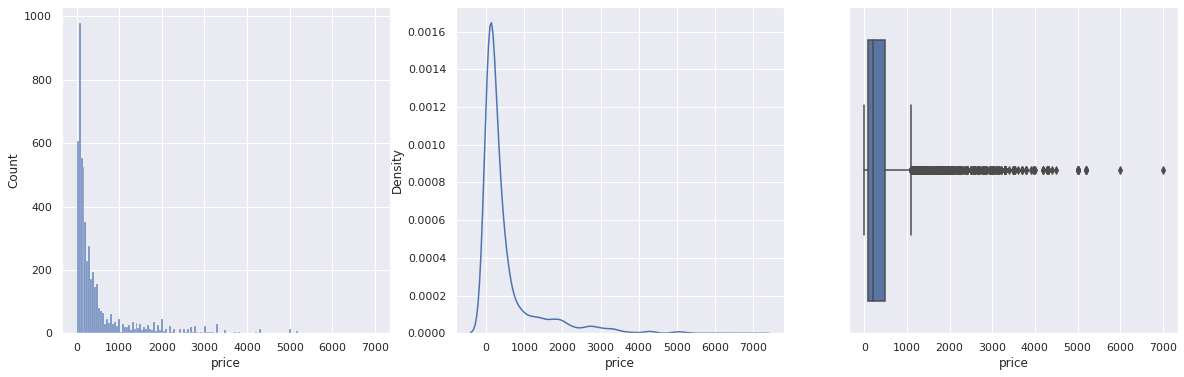

In [14]:
fig, ax = plt.subplots(1,3, squeeze=False, figsize=(20,6))
_ = sns.histplot(x='price', data=ep_data, ax=ax[0][0])
_ = sns.kdeplot(x='price', data=ep_data, ax=ax[0][1])
_ = sns.boxplot(x='price', data=ep_data, ax=ax[0][2])

##Initial Exploratory Data Analysis

### id
Summary: Not sure if there is any pattern to id, other than it is interesting that the top id occurs 41 times. Let's defer further analysis of this feature to a subsequent iteration of the model.
Decision: drop id

In [15]:
ep_data['id'].value_counts()
ep_data['id'].describe(include='object')

count                     5436
unique                     819
top       AV1YFZVDvKc47QAVgp7V
freq                        41
Name: id, dtype: object

In [16]:
columns_to_drop.append('id')

### prices.availability
####Summary: 
Interesting mixture of different words and phrases that are used to signify availability. May need to collapse as: {In Stock, Yes, yes, TRUE, 7 available}, {Out of Stock, More on the Way, sold, No, FALSE, Retired} {Special Order, undefined}
####Decision:
Recode to collect availability status into meaningful groups, then drop the column



In [17]:
ep_data['prices.availability'].value_counts()

In Stock           2395
Yes                1590
yes                 657
TRUE                513
Out Of Stock         89
Special Order        80
More on the Way      63
undefined            28
sold                 14
No                    4
Retired               1
FALSE                 1
7 available           1
Name: prices.availability, dtype: int64

In [18]:
def group_price_availability(availability):
  mapping = {
      'in stock': 'IN STOCK',
      'yes': 'IN STOCK',
      'true': 'IN STOCK',
      'false': 'OUT OF STOCK',
      'no': 'OUT OF STOCK',
      'undefined': 'UNKNOWN'
  }
  try:
    return mapping[availability.lower()]
  except:
    return 'OUT OF STOCK'

ep_data['availability_cleaned'] = ep_data['prices.availability'].apply(group_price_availability)
ep_data['availability_cleaned'] = ep_data['availability_cleaned'].astype('category')




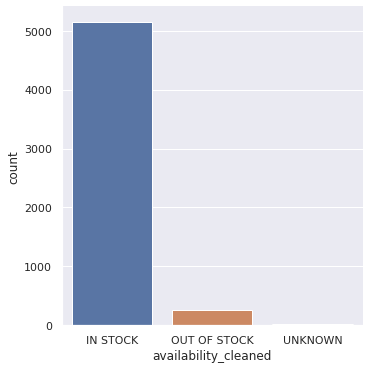

In [19]:
sns.catplot(x='availability_cleaned', kind='count', data=ep_data)

In [21]:
ep_data.groupby(['availability_cleaned']) \
.agg({'id':'count','price':'median'}) \
.rename(columns={'price':'price_median'}) \
.sort_values(by='id', ascending=False)

,id,price_median
availability_cleaned,,
IN STOCK,5155,192.25
OUT OF STOCK,253,198.99
UNKNOWN,28,214.99


In [22]:
columns_to_drop.append('prices.availability')



### prices.condition
#### Summary:
{New, new}, {Used, pre-owned}, {New other (see details)}, {Manufacturer refurbished, Seller refurbished, Refurbished, refurbished} and one data entry error with a long string "New Kicker..."
#### Decision:
Recode to collect availability status into meaningful groups and then drop prices.condition



In [23]:
ep_data['prices.condition'].value_counts()

New                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

{New, new}, {Used, pre-owned}, {New other (see details)}, {Manufacturer refurbished, Seller refurbished, Refurbished, refurbished} and one data entry error with a long string "New Kicker..."


In [24]:
def group_price_condition(condition):
  mapping = {
      'new': 'NEW',
      'used': 'USED',
      'manufacturer refurbished': 'REFURB',
      'seller refurbished': 'REFURB',
      'refurbished': 'REFURB',
      'pre-owned': 'USED',
      'new other (see details)': 'OTHER'
  }
  try:
    return mapping[condition.lower()]
  except:
    return 'OTHER'

ep_data['condition_cleaned'] = ep_data['prices.condition'].apply(group_price_condition)
ep_data['condition_cleaned'] = ep_data['condition_cleaned'].astype('category')
ep_data['condition_cleaned'].value_counts()



NEW       5182
USED       121
REFURB      68
OTHER       65
Name: condition_cleaned, dtype: int64

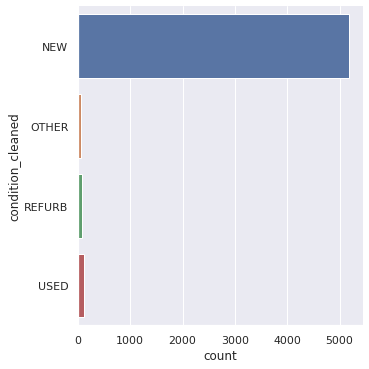

In [25]:
sns.catplot(y='condition_cleaned', kind='count', data=ep_data)

In [26]:
ep_data.groupby(['condition_cleaned']) \
.agg({'id':'count', 'price':'median'}) \
.rename(columns={'price':'price_median'}) \
.sort_values(by='id', ascending=False)

,id,price_median
condition_cleaned,,
NEW,5182,198.00
USED,121,148.00
REFURB,68,107.49
OTHER,65,109.99


In [27]:
columns_to_drop.append('prices.condition')



### prices.currency
#### Summary:
One observation with CAD, all the rest are USD. May need to convert this to USD based on prices.dateSeen date?
#### Decision:
Keep, may need to convert the one row in CAD to USD. Not enough information to know if price for this row is really in USD and it was just a data entry error for the prices.currency column.


In [28]:
ep_data['prices.currency'].value_counts()

USD    5435
CAD       1
Name: prices.currency, dtype: int64

One observation with CAD, all the rest are USD. May need to convert this to USD based on prices.dateSeen date?

In [29]:
columns_to_drop.append('prices.currency')

In [30]:
ep_data[ep_data['prices.currency'] == 'CAD']

,id,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,ean,imageURLs,keys,manufacturer,manufacturerNumber,name,primaryCategories,sourceURLs,upc,weight,price,availability_cleaned,condition_cleaned
1317,AVpe6fQ1ilAPnD_xQvv9,yes,New other (see details),CAD,2017-09-28T02:00:00Z,False,rideausales,CAD 18.61,http://www.ebay.com/itm/V-Moda-Boom-Pro-Microp...,"B00A39PPI0,B00BJ17WKK",V-Moda,"Computers,Stereos,Microphones & Headsets,Audio...",2015-09-11T00:50:06Z,2018-06-20T15:47:05Z,"8,776,530,058,490,870,000,000,000",http://ecx.images-amazon.com/images/I/41WfbQw%...,"0877653006563,vmodacrossfadewirelessheadphones...",V-Moda,XFBTPHCRM,V-MODA Crossfade Wireless Over-Ear Headphones ...,Electronics,http://www.ebay.com/itm/V-Moda-Boom-Pro-Microp...,8.78E+11,2 pounds,39.99,IN STOCK,OTHER




### prices.dateSeen
#### Summary:
There are multiple observations per row, comma separated and each observation appears to be in ISO8601 format. We could find the count of how many times the item price was seen, find the latest datetime and earliest datetime and then extract date and time details.
#### Decision:
For this iteration, let's extract just the latest datetime and then capture salient date and time details. Drop prices.dateSeen


In [31]:
ep_data['prices.dateSeen']

0               2017-05-10T20:00:00Z,2017-05-09T15:00:00Z
1       2017-10-10T02:00:00Z,2017-08-12T03:00:00Z,2017...
2       2017-10-10T19:00:00Z,2017-09-12T14:00:00Z,2017...
3       2017-09-08T05:00:00Z,2017-09-18T13:00:00Z,2017...
4                                    2017-12-05T13:00:00Z
                              ...                        
5431            2017-03-30T05:00:00Z,2017-03-30T11:00:00Z
5432    2017-12-07T08:00:00Z,2017-12-04T22:00:00Z,2017...
5433                                 2017-08-10T02:00:00Z
5434                                 2017-12-08T01:00:00Z
5435            2018-03-24T00:00:00Z,2018-03-19T18:00:00Z
Name: prices.dateSeen, Length: 5436, dtype: object

In [32]:
# Note:
# Could also have returned number of times seen as len(set(date_obj_list))
# and earliest date and earliest time seen with min(date_obj_list).date() and min(date_obj_list).time()

def process_date_seen(r):
  r_list = r.split(',')
  date_obj_list = [isoparse(x) for x in r_list]
  return  max(date_obj_list).date(), \
          max(date_obj_list).time()

# https://www.programiz.com/python-programming/datetime/strftime
def date_details(r):
  return int(r.strftime('%Y')), \
        int(r.strftime('%-m')), \
        int(r.strftime('%-d')), \
        int(r.strftime('%w'))

def time_details(r):
  return int(r.strftime('%-H')), \
         r.strftime('%p')
          

In [33]:
# https://stackoverflow.com/questions/23586510/return-multiple-columns-from-pandas-apply
ep_data['latestDateSeen'], ep_data['latestTimeSeen'] = zip(*ep_data['prices.dateSeen'].apply(process_date_seen))


In [34]:
ep_data[['latestDateSeen','latestTimeSeen']].head()

,latestDateSeen,latestTimeSeen
0,2017-05-10,20:00:00
1,2017-10-10,02:00:00
2,2017-10-10,19:00:00
3,2017-09-18,13:00:00
4,2017-12-05,13:00:00


In [35]:
ep_data['latestDateSeenYear'], ep_data['latestDateSeenMonth'], ep_data['latestDateSeenDay'], ep_data['latestDateSeenDayOfWeek']  = zip(*ep_data['latestDateSeen'].apply(date_details))
ep_data['latestTimeSeen24H'], ep_data['latestTimeSeenAMPM'] = zip(*ep_data['latestTimeSeen'].apply(time_details))

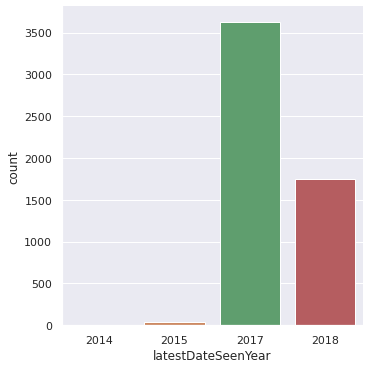

In [36]:
sns.catplot(x='latestDateSeenYear', kind='count', data=ep_data)

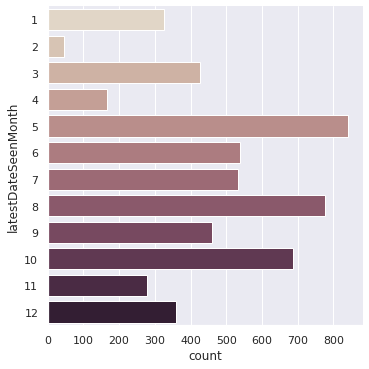

In [37]:
sns.catplot(y='latestDateSeenMonth', kind='count', palette="ch:.25", data=ep_data.sort_values(by='latestDateSeenMonth'))

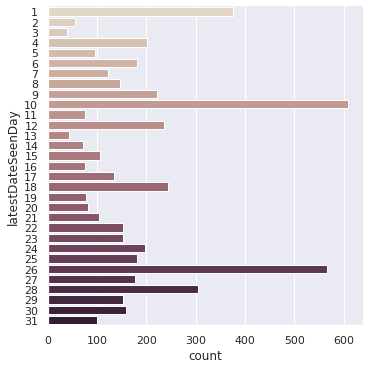

In [38]:
sns.catplot(y='latestDateSeenDay', kind='count', palette="ch:.25", data=ep_data.sort_values(by='latestDateSeenDay'))

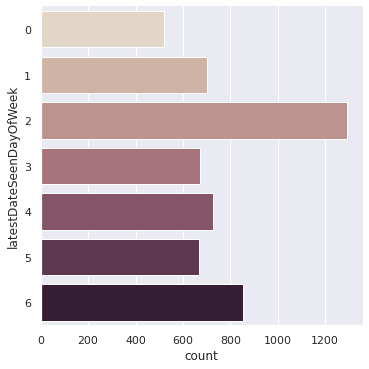

In [39]:
sns.catplot(y='latestDateSeenDayOfWeek', kind='count', palette="ch:.25", data=ep_data.sort_values(by='latestDateSeenDayOfWeek'))

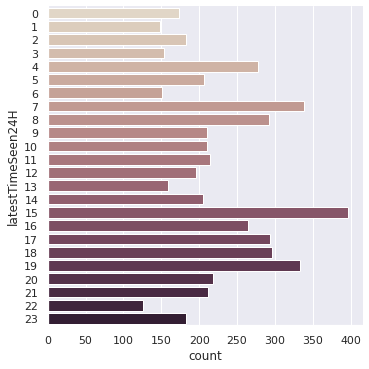

In [40]:
sns.catplot(y='latestTimeSeen24H', kind='count', palette="ch:.25", data=ep_data.sort_values(by='latestTimeSeen24H'))

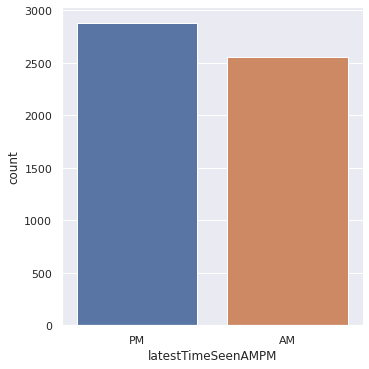

In [41]:
sns.catplot(x='latestTimeSeenAMPM', kind='count', data=ep_data)

In [42]:
ep_data[['latestDateSeenYear','latestDateSeenMonth','latestDateSeenDay','latestDateSeenDayOfWeek','latestDateSeenDayOfWeek','latestTimeSeenAMPM']].describe()

,latestDateSeenYear,latestDateSeenMonth,latestDateSeenDay,latestDateSeenDayOfWeek,latestDateSeenDayOfWeek
count,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000
mean,2017.303716,7.009382,16.450699,3.068065,3.068065
std,0.521756,2.951385,9.247867,1.910741,1.910741
min,2014.000000,1.000000,1.000000,0.000000,0.000000
25%,2017.000000,5.000000,9.000000,2.000000,2.000000
50%,2017.000000,7.000000,17.000000,3.000000,3.000000
75%,2018.000000,9.000000,26.000000,5.000000,5.000000
max,2018.000000,12.000000,31.000000,6.000000,6.000000


In [43]:
columns_to_drop.extend(['prices.dateSeen','latestDateSeen','latestTimeSeen'])



### prices.isSale
#### Summary:
#### Decision:




In [44]:
ep_data['prices.isSale'].value_counts()

False    4109
True     1327
Name: prices.isSale, dtype: int64

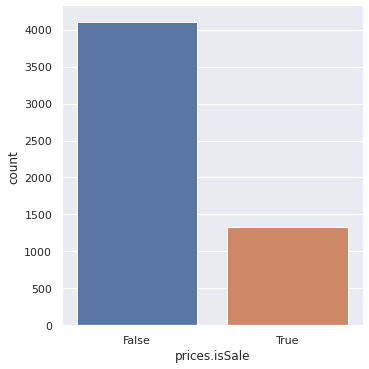

In [45]:
sns.catplot(x='prices.isSale', kind='count', data=ep_data)



### prices.merchant
Top 5 are Best Buy, B&H Photo Video, Walmart, Beach Camera, AMI Ventures Inc


In [46]:
ep_data['prices.merchant'].value_counts()

Bestbuy.com         2109
bhphotovideo.com    1119
Walmart.com          512
Beach Camera         153
AMI Ventures Inc      46
                    ... 
topusedcomputers       1
mpe007                 1
electricdiamond        1
a4c                    1
offers.store           1
Name: prices.merchant, Length: 587, dtype: int64



### prices.shipping

A mix of shipping type {FREE, Value, Standard, Expedited, Free Delivery, ...} and shipping cost. Shipping costs seem to be prepended with currency e.g. USD 6.65


In [47]:
ep_data['prices.shipping'].value_counts()

Free Expedited Shipping for most orders over $49    1075
FREE                                                 542
Value                                                517
Standard                                             507
Expedited                                            320
Freight                                               77
Free Delivery                                         46
Free Expedited Shipping                               36
Free Shippingon orders 35 and up                      12
Free Shipping on orders 35 and up                      5
Free Shipping                                          4
Free Standard Shipping on Orders Over $49              3
USD 6.65                                               3
USD 2.99                                               2
USD 14.00                                              2
Free Shipping for this Item                            2
USD 5.00                                               2
USD 150.00                     

In [48]:
# https://regex101.com/
s = 'USD 6.6'
r = r'(USD\s|CAD\s)(\d*\.?\d+)'
match = re.search(r, s)
print(match)

<_sre.SRE_Match object; span=(0, 7), match='USD 6.6'>





### brand

High cardinality: 254 brands


In [49]:
ep_data['brand'].value_counts()

Sony                  578
Samsung               565
Apple                 188
Yamaha                183
Pioneer               137
                     ... 
Hauppauge               1
I.am+                   1
VXi                     1
Diamond Multimedia      1
Lorex                   1
Name: brand, Length: 254, dtype: int64


### categories
#### Summary:
High cardinality: 792 categories. May be possible to bucket these.
#### Decision:


In [50]:
ep_data['categories'].value_counts()

Computers,Internal Hard Drives,Network Attached Storage Drives etryvwsrbvvvvxfutbey,Internal Drives,Drives, Storage & Blank Media,Computers & Accessories,Networking,Hard Drives (HDD, SSD & NAS),Computer Accessories & Peripherals,Internal Hard Disk Drives,Electronics,Hard Drives & Storage,Drives Storage,Computers/Tablets & Networking,Computer Components,NAS Servers,Computers & Tablets,Network Attached Storage Drives,Data Storage    41
TVs & Electronics,4K Ultra HD TVs,LCD TVs,Samsung Smart TVs,Samsung Tax Time Savings,TV, Video & Home Audio,Electronics,Shop TVs by Type,Televisions,TVs Entertainment,TV & Home Theater,All Flat-Panel TVs,4K Samsung TVs,LED & LCD TVs,All TVs,Consumer Electronics,TVs,Refurbished TVs,TV & Video,4K TVs by Brand,Smart TVs by Brand,Television & Video,LED TVs                                                                                 38
TVs & Electronics,4K Ultra HD TVs,LCD TVs,Samsung Tax Time Savings,TV, Video & Home Audio,Electronics,Shop TVs by Type,Telev

In [51]:
ep_data.groupby(['categories']).agg({'id':'count', 'price':'median'}).rename(columns={'price':'price_median'}).sort_values(by='id', ascending=False)

,id,price_median
categories,,
"Computers,Internal Hard Drives,Network Attached Storage Drives etryvwsrbvvvvxfutbey,Internal Drives,Drives, Storage & Blank Media,Computers & Accessories,Networking,Hard Drives (HDD, SSD & NAS),Computer Accessories & Peripherals,Internal Hard Disk Drives,Electronics,Hard Drives & Storage,Drives Storage,Computers/Tablets & Networking,Computer Components,NAS Servers,Computers & Tablets,Network Attached Storage Drives,Data Storage",41,492.000
"TVs & Electronics,4K Ultra HD TVs,LCD TVs,Samsung Smart TVs,Samsung Tax Time Savings,TV, Video & Home Audio,Electronics,Shop TVs by Type,Televisions,TVs Entertainment,TV & Home Theater,All Flat-Panel TVs,4K Samsung TVs,LED & LCD TVs,All TVs,Consumer Electronics,TVs,Refurbished TVs,TV & Video,4K TVs by Brand,Smart TVs by Brand,Television & Video,LED TVs",38,1331.970
"TVs & Electronics,4K Ultra HD TVs,LCD TVs,Samsung Tax Time Savings,TV, Video & Home Audio,Electronics,Shop TVs by Type,Televisions,TVs Entertainment,TV & Home Theater,All Flat-Panel TVs,LED & LCD TVs,4K Samsung TVs,All TVs,Consumer Electronics,TVs,Refurbished TVs,TV & Video,See more Samsung Un65mu9000 65 Inch UHD 4k Smart TV and...,4K TVs by Brand,Television & Video,LED TVs,4K Ultra HDTVs",37,2497.990
"Electronics,Shop TVs by Type,TVs Entertainment,Televisions,Tvs & Home Theater,Tvs,All TVs,Featured Brands,Refurbished TVs,4K TVs by Brand,Television & Video,4K Ultra HDTVs,TVs & Electronics,4K Ultra HD TVs,TV, Video & Home Audio,Electronics Features,4k Tv,Electronics Deals,TV & Home Theater,All Flat-Panel TVs,OLED TVs,Consumer Electronics,TV & Video,4K LG TVs,Smart TVs",36,2933.980
"4K Ultra HD TVs,Samsung Smart TVs,Samsung Tax Time Savings,TV, Video & Home Audio,Electronics,Shop TVs by Type,Televisions,TVs Entertainment,TV & Home Theater,LED & LCD TVs,All TVs,Consumer Electronics,TVs,Refurbished TVs,TV & Video,Smart TVs by Brand,Television & Video,LED TVs",36,1673.975
...,...,...
"Headphones,Bluetooth Headphones,All Headphones,Electronics,Earbud & In-Ear Headphones,Audio,Shop Headphones by Type,Earbuds and In-ear Headphones,Mobile",1,199.000
"Electrical,Household Batteries,AA Batteries,Consumer Electronics,Multipurpose Batteries & Power,Rechargeable Batteries,Frys,Electronic Components,Batteries - Rechargeable,Batteries,electronics,Household Supplies",1,26.020
"TVs,LED & LCD TVs,Outdoor TVs,Electronics,Television & Video,TVs Entertainment,Televisions,TV & Home Theater",1,2799.990



###dateAdded and dateUpdated
####Summary:
May be able to use datediff approach to find age of price information. My initial hunch is that these two columns capture database information and these may be candidates to drop. We could find the datediff between dateUpdated and dateAdded and also with dateSeen.
####Decision:


In [52]:
ep_data['dateAdded'].value_counts()

2017-03-06T14:57:09Z    53
2017-07-18T23:43:15Z    41
2017-03-03T16:56:09Z    40
2017-03-13T18:09:46Z    38
2017-06-23T02:19:30Z    37
                        ..
2014-02-21T05:30:31Z     1
2018-04-13T02:10:44Z     1
2015-08-18T18:41:52Z     1
2018-05-01T02:26:30Z     1
2018-04-21T21:03:18Z     1
Name: dateAdded, Length: 784, dtype: int64

In [53]:
ep_data['dateUpdated'].value_counts()

2018-07-26T15:55:15Z    44
2018-06-16T02:07:00Z    41
2018-06-25T02:00:22Z    38
2018-06-21T21:36:23Z    37
2018-06-07T01:22:23Z    36
                        ..
2018-01-20T04:21:12Z     1
2018-06-29T20:22:05Z     1
2018-06-29T20:20:58Z     1
2018-06-13T19:45:11Z     1
2018-05-29T17:19:04Z     1
Name: dateUpdated, Length: 727, dtype: int64

In [54]:
def process_date_added(x):
  try:
    date_obj = isoparse(x)
  except:
    date_obj = isoparse('2999-12-31T00:00:00Z')
  return date_obj.date(), date_obj.time()

ep_data['dateAdded_cleaned'], ep_data['timeAdded_cleaned']  = zip(*ep_data['dateAdded'].apply(process_date_added))
ep_data['dateUpdated_cleaned'], ep_data['timeUpdated_cleaned']  = zip(*ep_data['dateUpdated'].apply(process_date_added))
ep_data['dateDiffUpdated_Added'] = ep_data['dateUpdated_cleaned'] - ep_data['dateAdded_cleaned']
# Assume that observation updated should be close to observation last seen (+vs delta)
ep_data['dateDiffUpdated_Seen'] = ep_data['dateUpdated_cleaned'] - ep_data['latestDateSeen']
# Assume that observation added should be before observation last seen (+ve delta)
ep_data['dateDiffSeen_Added'] = ep_data['latestDateSeen'] - ep_data['dateAdded_cleaned']
ep_data.drop(labels=['dateAdded','dateUpdated'], axis=1, inplace=True)

In [55]:
ep_data['dateAdded_cleaned']

0       2015-11-01
1       2017-03-13
2       2014-10-28
3       2015-11-06
4       2017-07-18
           ...    
5431    2017-03-03
5432    2015-11-06
5433    2017-07-18
5434    2014-02-20
5435    2015-05-18
Name: dateAdded_cleaned, Length: 5436, dtype: object

In [56]:
ep_data['dateUpdated_cleaned']

0       2018-02-13
1       2018-01-30
2       2018-05-16
3       2018-01-30
4       2018-07-26
           ...    
5431    2018-05-16
5432    2018-07-26
5433    2018-07-26
5434    2018-05-02
5435    2018-07-26
Name: dateUpdated_cleaned, Length: 5436, dtype: object

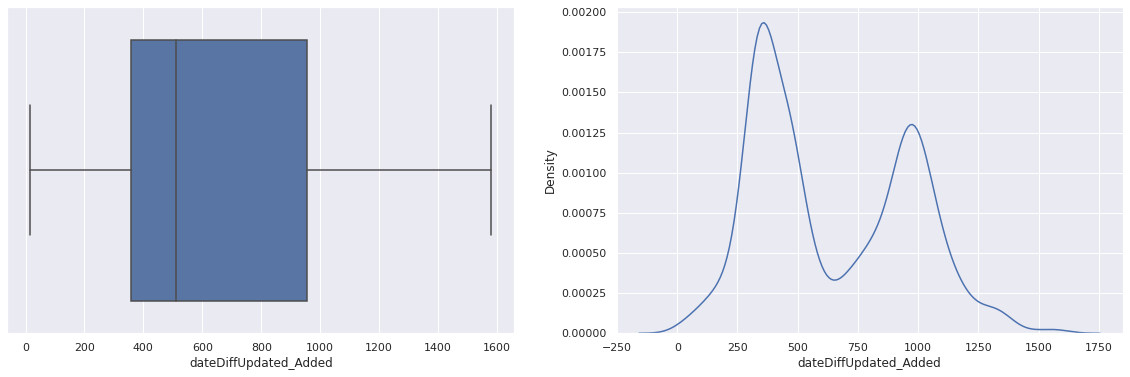

In [57]:
# https://stackoverflow.com/questions/33605514/how-to-extract-days-as-integers-from-a-timedelta64ns-object-in-python/33605894
ep_data['dateDiffUpdated_Added'] = ep_data['dateDiffUpdated_Added'].astype('timedelta64[D]')
fig, ax = plt.subplots(1,2, squeeze=False, figsize=(20,6))
_ = sns.boxplot(x='dateDiffUpdated_Added', data=ep_data, ax=ax[0][0])
_ = sns.kdeplot(x='dateDiffUpdated_Added', data=ep_data, ax=ax[0][1])

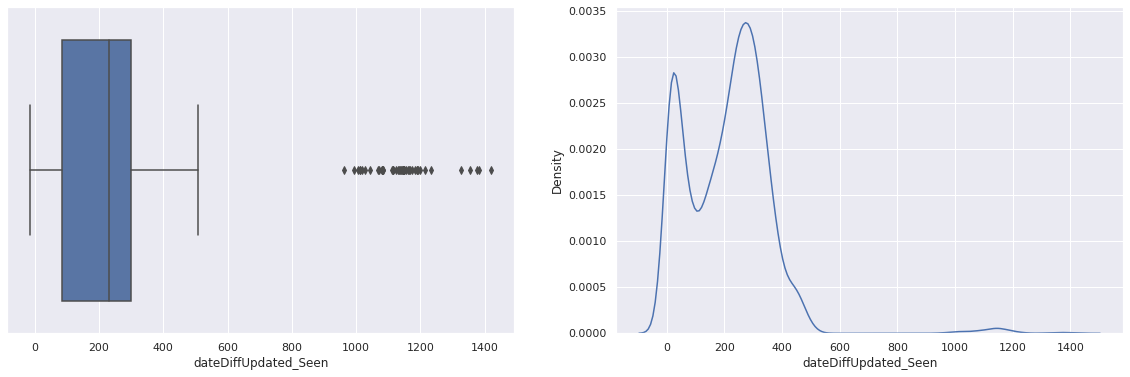

In [58]:
ep_data['dateDiffUpdated_Seen'] = ep_data['dateDiffUpdated_Seen'].astype('timedelta64[D]')
fig, ax = plt.subplots(1,2, squeeze=False, figsize=(20,6))
_ = sns.boxplot(x='dateDiffUpdated_Seen', data=ep_data, ax=ax[0][0])
_ = sns.kdeplot(x='dateDiffUpdated_Seen', data=ep_data, ax=ax[0][1])

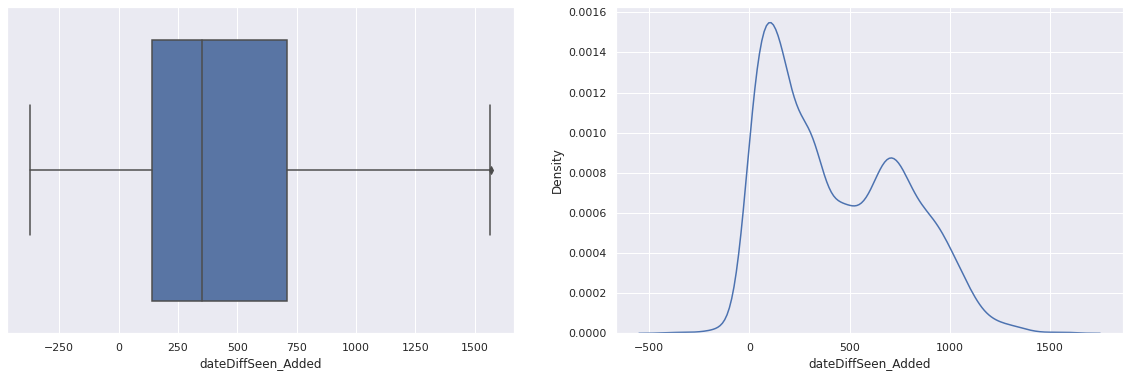

In [59]:
ep_data['dateDiffSeen_Added'] = ep_data['dateDiffSeen_Added'].astype('timedelta64[D]')
fig, ax = plt.subplots(1,2, squeeze=False, figsize=(20,6))
_ = sns.boxplot(x='dateDiffSeen_Added', data=ep_data, ax=ax[0][0])
_ = sns.kdeplot(x='dateDiffSeen_Added', data=ep_data, ax=ax[0][1])

In [60]:
columns_to_drop.extend(['dateAdded_cleaned','dateUpdated_cleaned'])

### manufacturer
#### Summary:
#### Decision:



In [61]:
ep_data['manufacturer'].value_counts()

Sony                  179
Samsung               132
Apple                 101
Pioneer                78
Yamaha                 52
                     ... 
Lenovo                  1
AUDIOQUEST              1
Sonax                   1
Diamond Multimedia      1
Lorex                   1
Name: manufacturer, Length: 197, dtype: int64

In [63]:
ep_data.groupby(['manufacturer']) \
.agg({'id':'count','price':'median'}) \
.rename(columns={'price':'price_median'}) \
.sort_values(by='id', ascending=False)

,id,price_median
manufacturer,,
Sony,179,239.99
Samsung,132,298.99
Apple,101,1444.99
Pioneer,78,118.99
Yamaha,52,249.97
...,...,...
AUDIOQUEST,1,79.98
Lorex,1,493.99
Sonax,1,35.99




```
primaryCategories
```
Not a very useful column at first blush.


In [64]:
ep_data['primaryCategories'].value_counts()

Electronics              5392
 Apple CarPlay             22
 Intel Celeron              9
Electronics,Furniture       8
 Siri Eyes Free             5
Name: primaryCategories, dtype: int64

In [65]:
columns_to_drop.append('primaryCategories')



```
weight
```
A mixture of lbs and ounces. Split numeric and units and then scale to ounces, perhaps? Check if metric measures are present.


In [66]:
ep_data['weight'].value_counts()

1 pounds       117
39.5 pounds     50
2 pounds        49
2.4 ounces      48
0.02 ounces     41
              ... 
11.7 ounces      1
41.5 lb          1
5.1 lb           1
13.2 pounds      1
9.2 oz           1
Name: weight, Length: 578, dtype: int64

In [67]:
ep_data['weight'][34]

'2.40 oz'

In [68]:
# try and split weight into numeric and units
# format looks like numeric price, space, units

weight_cleaned = ep_data['weight'].str.split(' ', n=1, expand=True)
weight_cleaned

,0,1
0,3,pounds
1,4.3,pounds
2,0.6,ounces
3,1,pounds
4,9.98,oz 4.09 oz
...,...,...
5431,8,ounces
5432,25.6,ounces
5433,6,oz
5434,2.7,Kg



Decision
```
dropping
ean, imageURLs, keys, sourceURLs, UPC
```



In [69]:
columns_to_drop.extend(['ean','imageURLs','sourceURLs','upc'])

In [70]:
print(columns_to_drop)
#ep_data.drop(labels=columns_to_drop, axis=1, inplace=True)

['prices.shipping', 'ean', 'manufacturer', 'id', 'prices.availability', 'prices.condition', 'prices.currency', 'prices.dateSeen', 'latestDateSeen', 'latestTimeSeen', 'dateAdded_cleaned', 'dateUpdated_cleaned', 'primaryCategories', 'ean', 'imageURLs', 'sourceURLs', 'upc']


In [71]:
ep_data.drop(labels=columns_to_drop, axis=1, inplace=True)

In [72]:
ep_data.columns

Index(['prices.isSale', 'prices.merchant', 'prices.sourceURLs', 'asins',
       'brand', 'categories', 'keys', 'manufacturerNumber', 'name', 'weight',
       'price', 'availability_cleaned', 'condition_cleaned',
       'latestDateSeenYear', 'latestDateSeenMonth', 'latestDateSeenDay',
       'latestDateSeenDayOfWeek', 'latestTimeSeen24H', 'latestTimeSeenAMPM',
       'timeAdded_cleaned', 'timeUpdated_cleaned', 'dateDiffUpdated_Added',
       'dateDiffUpdated_Seen', 'dateDiffSeen_Added'],
      dtype='object')

In [73]:
ep_data.head()

,prices.isSale,prices.merchant,prices.sourceURLs,asins,brand,categories,keys,manufacturerNumber,name,weight,price,availability_cleaned,condition_cleaned,latestDateSeenYear,latestDateSeenMonth,latestDateSeenDay,latestDateSeenDayOfWeek,latestTimeSeen24H,latestTimeSeenAMPM,timeAdded_cleaned,timeUpdated_cleaned,dateDiffUpdated_Added,dateDiffUpdated_Seen,dateDiffSeen_Added
0,False,Bestbuy.com,http://www.bestbuy.com/site/products/7100293.p...,B00I9HD8PK,Grace Digital,"Electronics,Home Audio & Theater,Home Audio,Al...","819127010485,ecoxgearecostonebluetoothspeaker/...",GDI-EGST701,EcoXGear Ecostone Bluetooth Speaker,3 pounds,92.99,IN STOCK,NEW,2017,5,10,3,20,PM,00:57:52,19:46:08,835.0,279.0,556.0
1,False,Bestbuy.com,https://www.bestbuy.com/site/lenovo-100s-14ibr...,B06ZY63J8H,Lenovo,"Electronics,Computers,Laptops,Laptops By Brand...","190793918948,lenovo100s14ibr14laptopintelceler...",100s-14ibr,Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...,4.3 pounds,229.99,IN STOCK,NEW,2017,10,10,2,2,AM,18:22:32,06:06:16,323.0,112.0,211.0
2,False,Bestbuy.com,https://www.bestbuy.com/site/house-of-marley-s...,B00G3P9UMU,House of Marley,"Headphones,Consumer Electronics,Portable Audio...","0846885007037,houseofmarleysmilejamaicainearea...",EM-JE041-MI,House of Marley Smile Jamaica In-Ear Earbuds,0.6 ounces,16.99,IN STOCK,NEW,2017,10,10,2,19,PM,18:47:20,20:23:54,1296.0,218.0,1078.0
3,False,Bestbuy.com,https://www.bestbuy.com/site/products/6311012....,B00TTWZFFA,Sony,"Electronics,Home Audio & Theater,Home Audio,Al...","sonyultraportablebluetoothspeaker/sosrsx11bk,s...",SRSX11/BLK,Sony Ultra-Portable Bluetooth Speaker,1 pounds,69.99,IN STOCK,NEW,2017,9,18,1,13,PM,00:24:21,03:06:18,816.0,134.0,682.0
4,True,bhphotovideo.com,https://www.bhphotovideo.com/c/product/1105014...,B00MHPAF38,Sony,"Digital Cameras,Cameras & Photo,Used:Digital P...",sonyalphaa5100digitalcamerakitwith1650mmlenswh...,ILCE5100L/W,Alpha a5100 Mirrorless Digital Camera with 16-...,9.98 oz 4.09 oz,846.00,OUT OF STOCK,NEW,2017,12,5,2,13,PM,23:35:50,15:58:38,373.0,233.0,140.0


##Feature Engineering


In [74]:
# prices.isSale boolean to binary encoding
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
!pip install category_encoders
import category_encoders as ce

     |████████████████████████████████| 81kB 3.9MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [75]:
ep_data_fe = ep_data.copy()

In [76]:
ep_data_fe.columns

Index(['prices.isSale', 'prices.merchant', 'prices.sourceURLs', 'asins',
       'brand', 'categories', 'keys', 'manufacturerNumber', 'name', 'weight',
       'price', 'availability_cleaned', 'condition_cleaned',
       'latestDateSeenYear', 'latestDateSeenMonth', 'latestDateSeenDay',
       'latestDateSeenDayOfWeek', 'latestTimeSeen24H', 'latestTimeSeenAMPM',
       'timeAdded_cleaned', 'timeUpdated_cleaned', 'dateDiffUpdated_Added',
       'dateDiffUpdated_Seen', 'dateDiffSeen_Added'],
      dtype='object')

In [77]:
bin_encoder = ce.BinaryEncoder(cols=['prices.isSale','latestTimeSeenAMPM'])
tmp = bin_encoder.fit_transform(ep_data_fe)

ohe_encoder = ce.OneHotEncoder(cols=['condition_cleaned'])
tmp = ohe_encoder.fit_transform(tmp)

tmp.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,prices.isSale_0,prices.isSale_1,prices.merchant,prices.sourceURLs,asins,brand,categories,keys,manufacturerNumber,name,weight,price,availability_cleaned,condition_cleaned_1,condition_cleaned_2,condition_cleaned_3,condition_cleaned_4,latestDateSeenYear,latestDateSeenMonth,latestDateSeenDay,latestDateSeenDayOfWeek,latestTimeSeen24H,latestTimeSeenAMPM_0,latestTimeSeenAMPM_1,timeAdded_cleaned,timeUpdated_cleaned,dateDiffUpdated_Added,dateDiffUpdated_Seen,dateDiffSeen_Added
0,0,1,Bestbuy.com,http://www.bestbuy.com/site/products/7100293.p...,B00I9HD8PK,Grace Digital,"Electronics,Home Audio & Theater,Home Audio,Al...","819127010485,ecoxgearecostonebluetoothspeaker/...",GDI-EGST701,EcoXGear Ecostone Bluetooth Speaker,3 pounds,92.99,IN STOCK,1,0,0,0,2017,5,10,3,20,0,1,00:57:52,19:46:08,835.0,279.0,556.0
1,0,1,Bestbuy.com,https://www.bestbuy.com/site/lenovo-100s-14ibr...,B06ZY63J8H,Lenovo,"Electronics,Computers,Laptops,Laptops By Brand...","190793918948,lenovo100s14ibr14laptopintelceler...",100s-14ibr,Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...,4.3 pounds,229.99,IN STOCK,1,0,0,0,2017,10,10,2,2,1,0,18:22:32,06:06:16,323.0,112.0,211.0
2,0,1,Bestbuy.com,https://www.bestbuy.com/site/house-of-marley-s...,B00G3P9UMU,House of Marley,"Headphones,Consumer Electronics,Portable Audio...","0846885007037,houseofmarleysmilejamaicainearea...",EM-JE041-MI,House of Marley Smile Jamaica In-Ear Earbuds,0.6 ounces,16.99,IN STOCK,1,0,0,0,2017,10,10,2,19,0,1,18:47:20,20:23:54,1296.0,218.0,1078.0
3,0,1,Bestbuy.com,https://www.bestbuy.com/site/products/6311012....,B00TTWZFFA,Sony,"Electronics,Home Audio & Theater,Home Audio,Al...","sonyultraportablebluetoothspeaker/sosrsx11bk,s...",SRSX11/BLK,Sony Ultra-Portable Bluetooth Speaker,1 pounds,69.99,IN STOCK,1,0,0,0,2017,9,18,1,13,0,1,00:24:21,03:06:18,816.0,134.0,682.0
4,1,0,bhphotovideo.com,https://www.bhphotovideo.com/c/product/1105014...,B00MHPAF38,Sony,"Digital Cameras,Cameras & Photo,Used:Digital P...",sonyalphaa5100digitalcamerakitwith1650mmlenswh...,ILCE5100L/W,Alpha a5100 Mirrorless Digital Camera with 16-...,9.98 oz 4.09 oz,846.00,OUT OF STOCK,1,0,0,0,2017,12,5,2,13,0,1,23:35:50,15:58:38,373.0,233.0,140.0


##Feature Importance


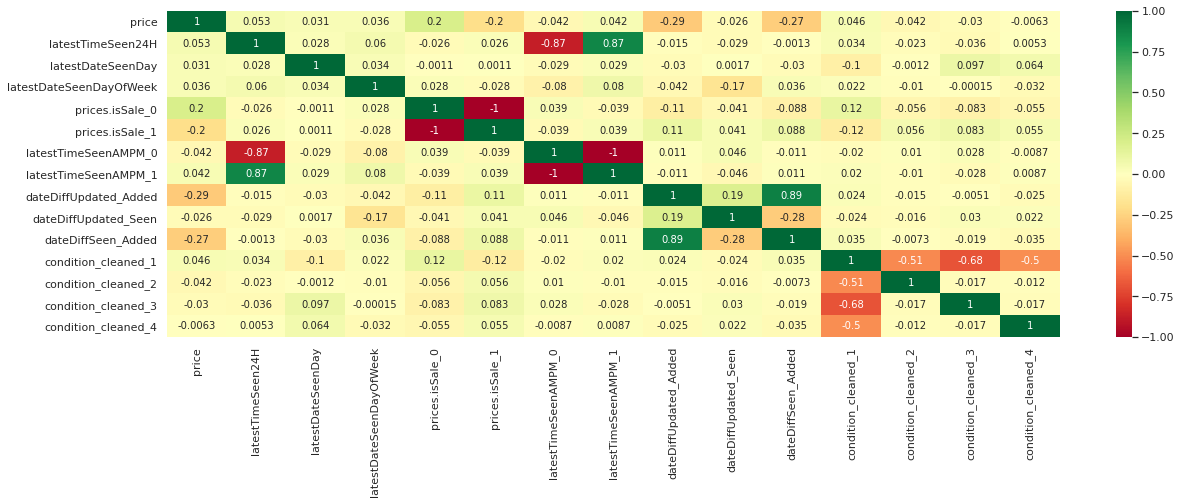

In [78]:
corr_mat = tmp[['price','latestTimeSeen24H','latestDateSeenDay','latestDateSeenDayOfWeek','prices.isSale_0','prices.isSale_1','latestTimeSeenAMPM_0','latestTimeSeenAMPM_1','dateDiffUpdated_Added', 'dateDiffUpdated_Seen',
       'dateDiffSeen_Added','condition_cleaned_1','condition_cleaned_2','condition_cleaned_3','condition_cleaned_4']].corr()
fig, ax = plt.subplots(1,1, squeeze=False, figsize=(20,6))
_ = sns.heatmap(corr_mat, annot=True, cmap='RdYlGn')